In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import pickle
import math
from scipy import stats
from datetime import datetime

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

#normalización
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#estandarización 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#encoders
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder

#metrics
from sklearn import metrics

#modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#scr
import sys
sys.path.append("../")
import src.support as sp

# input

In [2]:
df = pd.read_csv('../data/train.csv')
df.head()

id  carat        cut color clarity  depth  table     x     y     z  price
0   0   0.30    Premium     D     SI2   62.4   58.0  4.31  4.28  2.68  6.353
1   1   1.01      Ideal     E    VVS2   62.7   56.0  6.42  6.46  4.04  9.183
2   2   0.72      Ideal     F     VS2   61.8   59.0  5.71  5.74  3.54  7.983
3   3   1.08  Very Good     G     SI2   63.2   57.0  6.54  6.50  4.12  8.371
4   4   0.36    Premium     G     VS1   62.3   59.0  4.50  4.55  2.82  6.588

vamos a tomar la aproximación de que `depth` y `table` tienen poca relación con el precio y al ser similares a las variables `x`, `y`, `z` las eleminaré.

In [3]:
df.drop(['table', 'depth'], axis = 1, inplace=True)

# gestión de nulos

no hay nulos en este dataframe, por lo que pasamos al siguiente apartado.

In [4]:
# Número de datos nulos por columna

df.isnull().sum() / df.shape[0]

id         0.0
carat      0.0
cut        0.0
color      0.0
clarity    0.0
x          0.0
y          0.0
z          0.0
price      0.0
dtype: float64

# gestión de outliers

detección de outliers


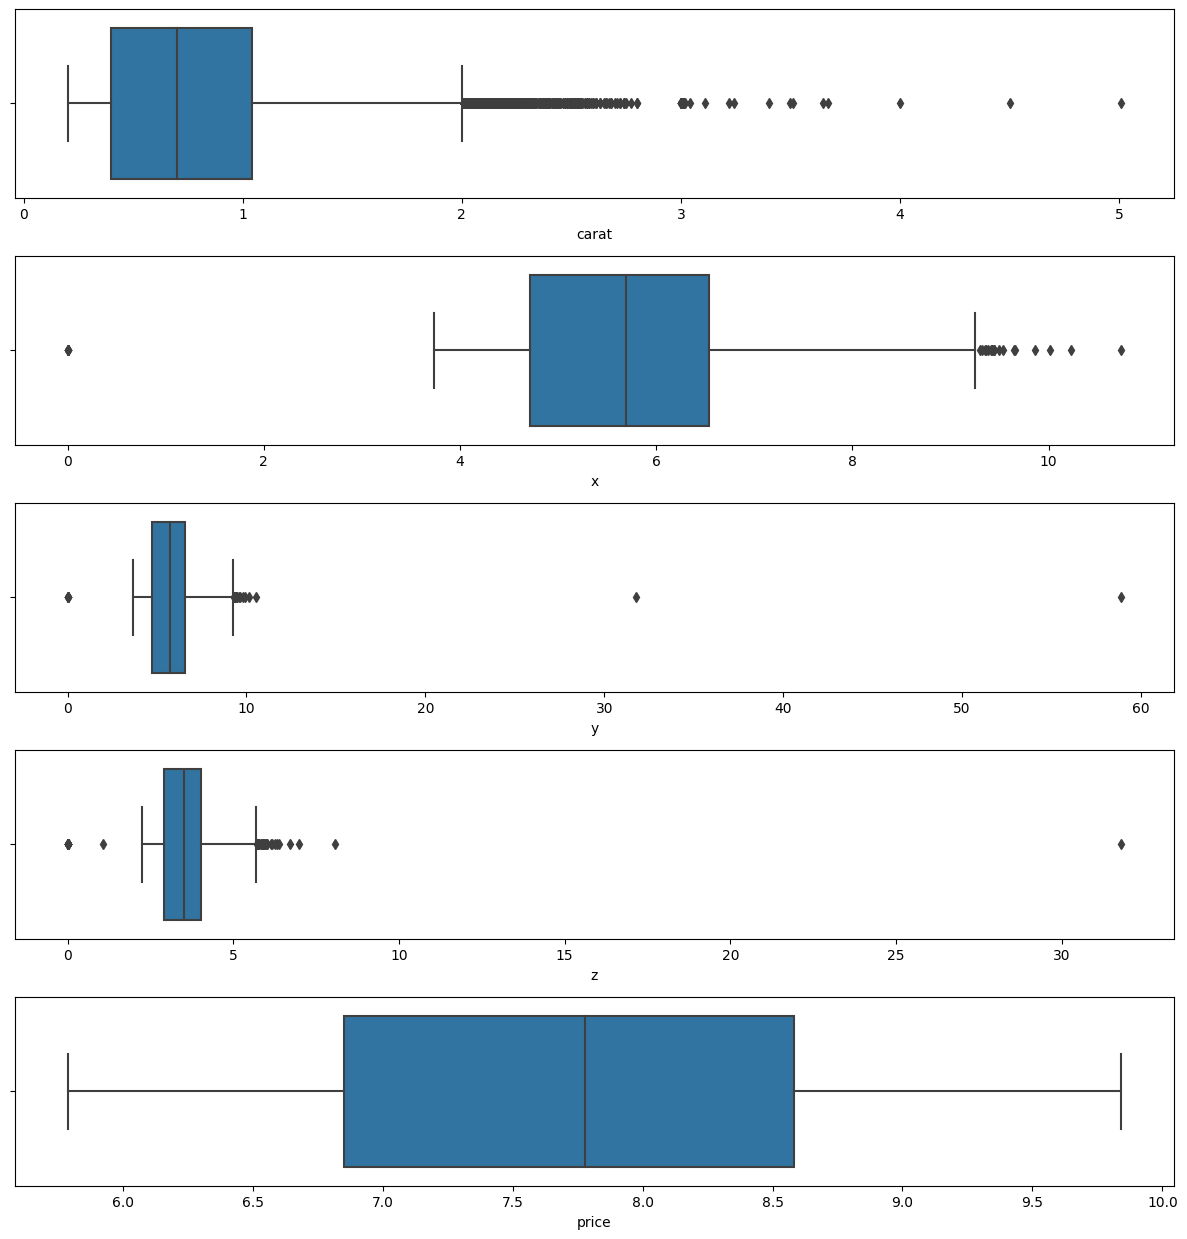

In [5]:
sp.chart_boxplot(df)

hay outliers en las columnas de `carat`, `x`, `y` y `z`.

# normalización

In [6]:
df_norm = df.copy()

original ShapiroResult(statistic=0.9629325270652771, pvalue=0.0) 
 log: ShapiroResult(statistic=0.9636465311050415, pvalue=0.0) 
 sqrt ShapiroResult(statistic=0.9639406800270081, pvalue=0.0) 
 bc: ShapiroResult(statistic=0.9639595150947571, pvalue=0.0)


id  carat        cut color clarity     x     y     z  price  \
0          0   0.30    Premium     D     SI2  4.31  4.28  2.68  6.353   
1          1   1.01      Ideal     E    VVS2  6.42  6.46  4.04  9.183   
2          2   0.72      Ideal     F     VS2  5.71  5.74  3.54  7.983   
3          3   1.08  Very Good     G     SI2  6.54  6.50  4.12  8.371   
4          4   0.36    Premium     G     VS1  4.50  4.55  2.82  6.588   
...      ...    ...        ...   ...     ...   ...   ...   ...    ...   
40450  40450   0.42    Premium     D     SI2  4.78  4.82  2.98  6.551   
40451  40451   0.53    Premium     G     VS2  5.21  5.18  3.22  7.382   
40452  40452   0.80       Good     G     SI2  5.86  5.90  3.69  7.768   
40453  40453   1.01  Very Good     F     VS2  6.40  6.48  3.96  8.726   
40454  40454   1.30    Premium     I     VS2  7.10  7.14  4.28  8.771   

       price_LOG  price_SQRT  price_BC  
0       1.848927    2.520516  2.273071  
1       2.217354    3.030347  2.845042  
2       2.077314    2.825420  2.622251  
3       2.124773    2.893268  2.697000  
4       1.885250    2.566710  2.327458  
...          ...         ...       ...  
40450   1.879618    2.559492  2.318997  
40451   1.999045    2.716984  2.500638  
40452   2.050013    2.787113  2.579597  
40453   2.166307    2.953980  2.763049  
40454   2.171451    2.961587  2.771270  

[40455 rows x 12 columns]

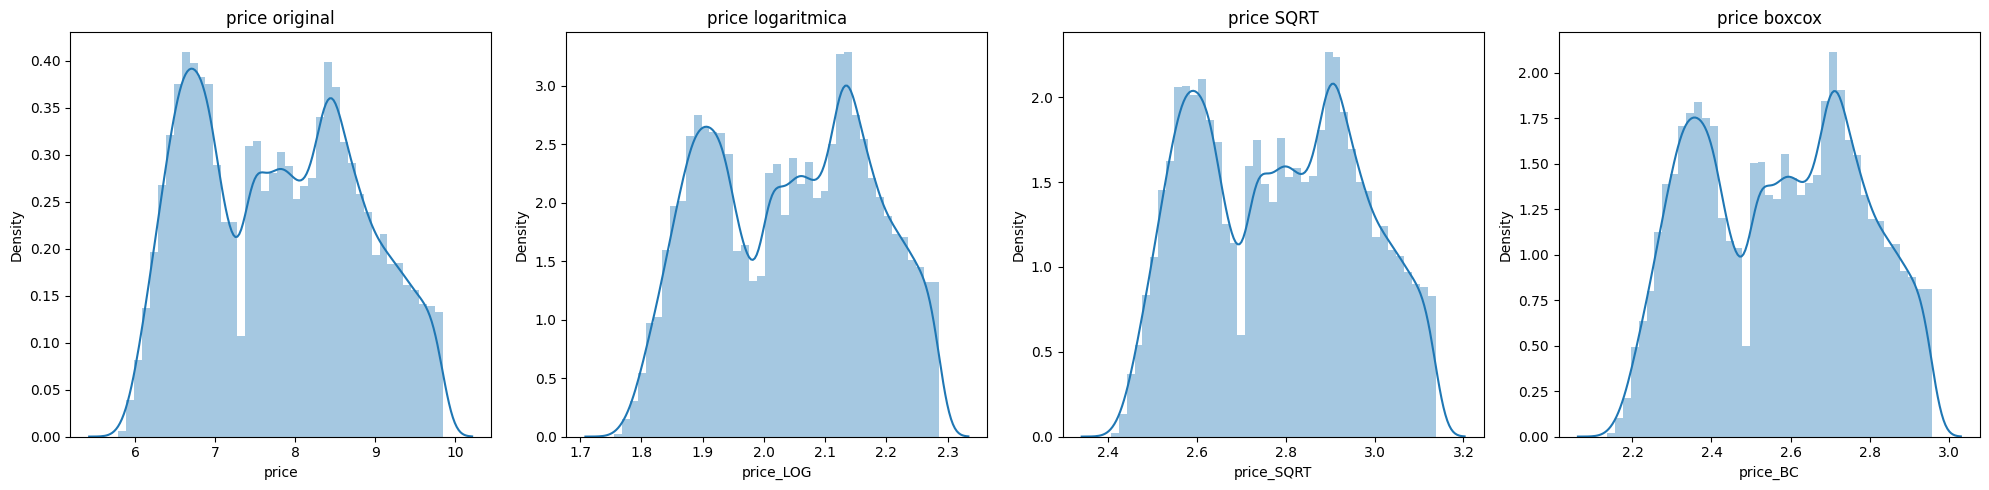

In [7]:
sp.normalizacion(df_norm, 'price')

viendo los resultados del test de shapiro, vemos que los datos no son normales en esta aproximación -> no merece la pena hacer una regresión lineal con ese planteamiento.

# estandarización

In [8]:
columns_estandar = df.select_dtypes(include = np.number).drop(['id', 'price'], axis = 1).columns
df[columns_estandar] = sp.estandarizacion(df, columns_estandar, 'mediana')
df.head()

id     carat        cut color clarity         x         y         z  price
0   0 -0.625000    Premium     D     SI2 -0.754098 -0.780220 -0.750000  6.353
1   1  0.484375      Ideal     E    VVS2  0.398907  0.417582  0.464286  9.183
2   2  0.031250      Ideal     F     VS2  0.010929  0.021978  0.017857  7.983
3   3  0.593750  Very Good     G     SI2  0.464481  0.439560  0.535714  8.371
4   4 -0.531250    Premium     G     VS1 -0.650273 -0.631868 -0.625000  6.588

# encoding

este chart da la distribución de las variables categóricas


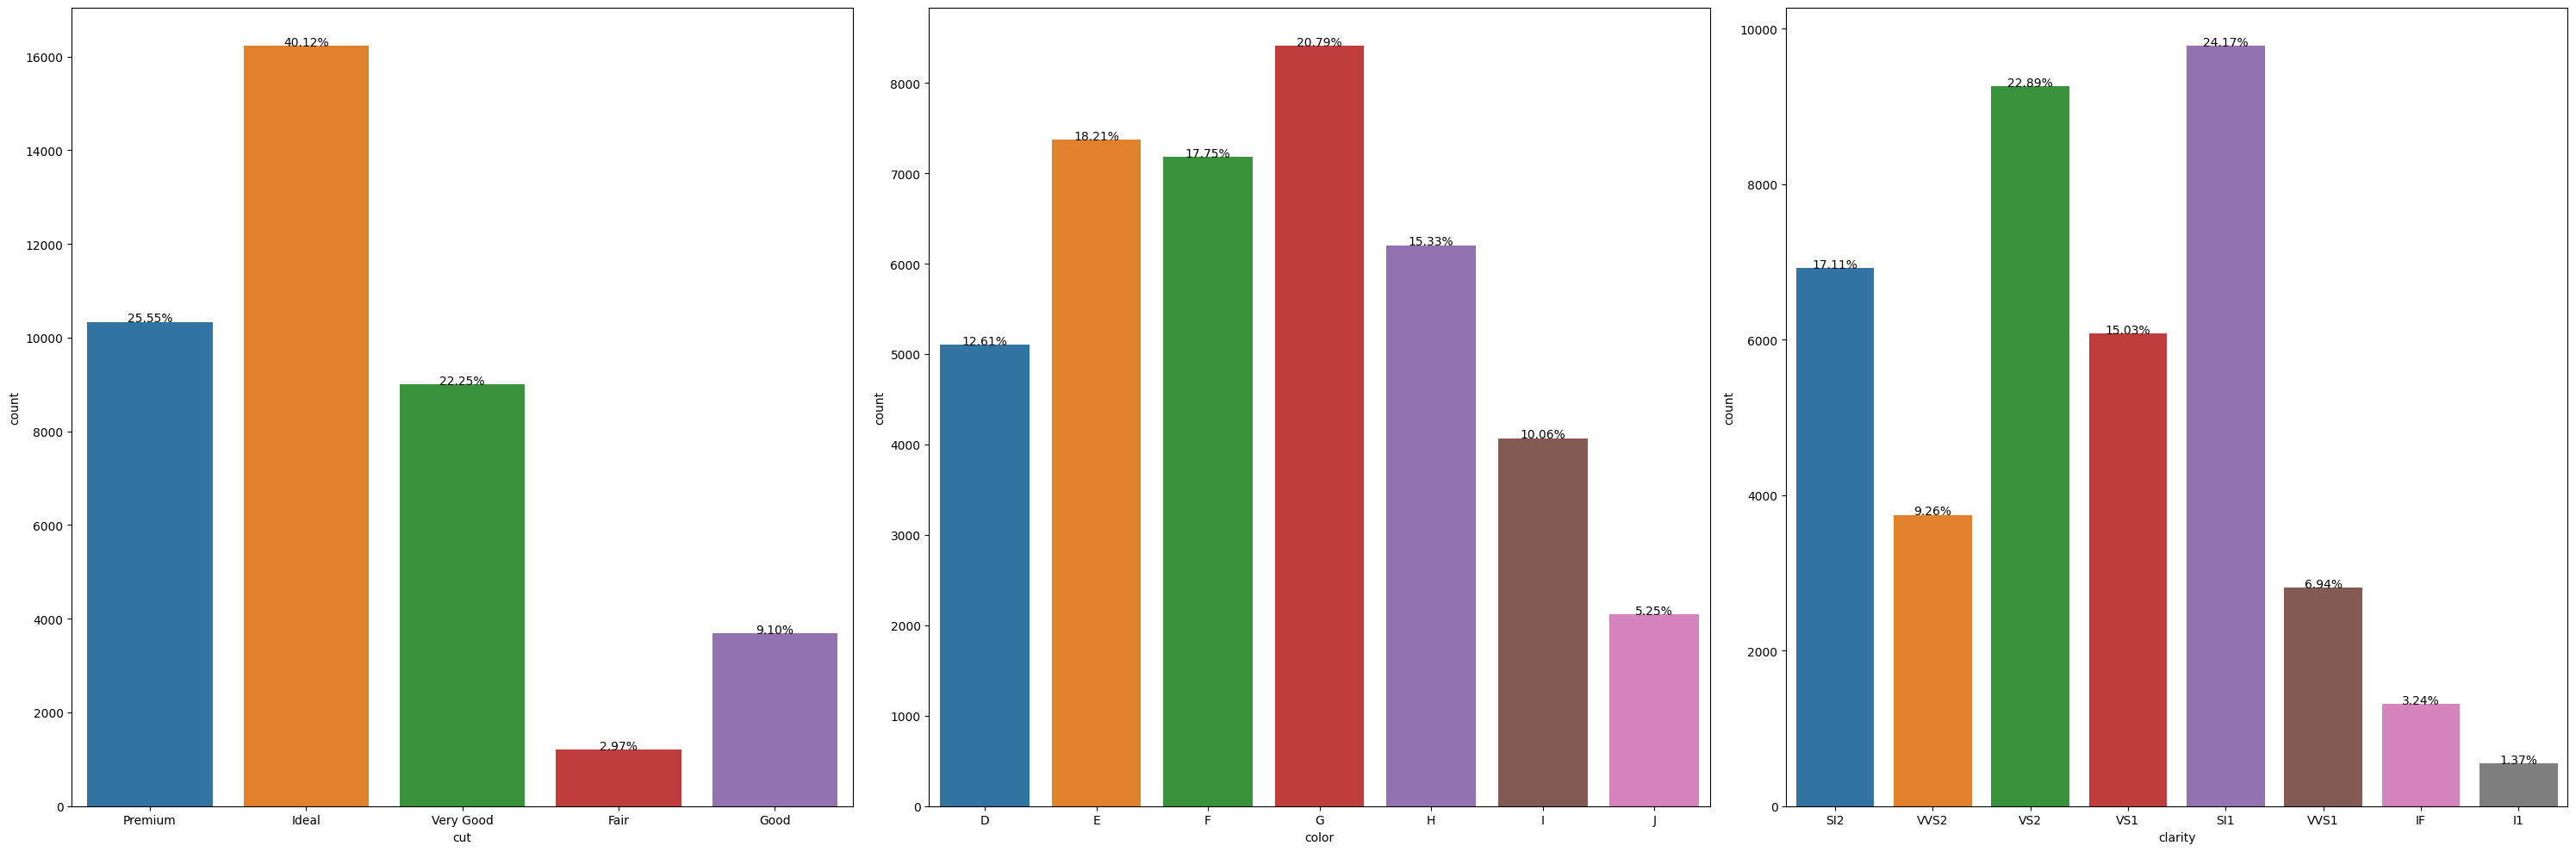

In [9]:
sp.chart_categoricas_count(df)

mirando las distrribuciones, parece que el dataframe tiene orden.

además, tenemos que tener en cuenta que las columnas de `cut`, `clarity` y `color` van a tener un orden teniendo en cuenta el valor que tienen a la hora de estimar el precio de un diamante. así, usaremos un encoding de tipo ordinal, para poder introducir la importancia de las variables con una lista.

In [10]:
order_clarity = ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF' , 'FL']
order_color = sorted(df.color.unique().tolist(), reverse=True)
order_cut = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

In [11]:
df = sp.ordinal_map(df, 'cut', order_cut)
df = sp.ordinal_map(df, 'color', order_color)
df = sp.ordinal_map(df, 'clarity', order_clarity)

In [12]:
df.head()

id     carat  cut  color  clarity         x         y         z  price
0   0 -0.625000    3      6        3 -0.754098 -0.780220 -0.750000  6.353
1   1  0.484375    4      5        7  0.398907  0.417582  0.464286  9.183
2   2  0.031250    4      4        5  0.010929  0.021978  0.017857  7.983
3   3  0.593750    2      3        3  0.464481  0.439560  0.535714  8.371
4   4 -0.531250    3      3        6 -0.650273 -0.631868 -0.625000  6.588

In [13]:
#columnas_cat = df.select_dtypes(include = 'object').columns#.tolist()
#sp.encoding(df, columnas_cat.tolist(), 'con orden')
#df.head()

# modelo
separamos entre modelo y test

In [14]:
df.head(1)

id  carat  cut  color  clarity         x        y     z  price
0   0 -0.625    3      6        3 -0.754098 -0.78022 -0.75  6.353

In [15]:
X = df.drop(['id', 'price'], axis = 1)
y = df[['price']]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

## linear regresion

no se puede sacar la linear regression.

## decission tree

In [17]:
y_pred_test, y_pred_train, max_features, max_depth = sp.decission_tree_params(X_train, y_train, X_test, y_test)

In [18]:
print('max features', math.ceil(max_features), 'max depth', max_depth)

max features 3 max depth 34


In [19]:
# sacamos las métricas para ver si hay overfitting

dt_results1 = sp.metricas(y_test, y_train, y_pred_test, y_pred_train, "Decission Tree I")
dt_results1

MAE       MSE      RMSE        R2    set            modelo
0  0.087403  0.017469  0.132170  0.982895   test  Decission Tree I
1  0.000374  0.000033  0.005703  0.999969  train  Decission Tree I

Start time: 2023-04-01 09:02:17.601535
End time: 2023-04-01 09:06:00.886734


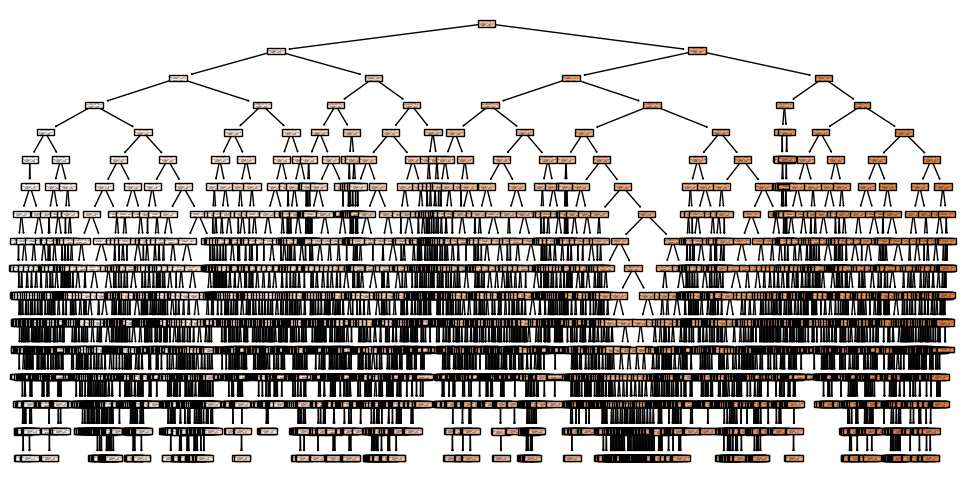

In [20]:
best_estimator, param = sp.modelos_grid_search(X_train, y_train, X_test, y_test, math.ceil(max_depth), max_features, 'DecisionTree')

In [21]:
print(best_estimator)

DecisionTreeRegressor(max_depth=16, max_features=2, min_samples_leaf=10,
                      min_samples_split=10)


In [23]:
y_pred_test, y_pred_train = sp.modelo_prediccion(X_train, y_train, X_test, y_test, 16, 2, 10, 10, input = 'DecisionTree')

In [24]:
# sacamos las métricas para ver si hay overfitting

dt_results2 = sp.metricas(y_test, y_train, y_pred_test, y_pred_train, "Decission Tree II")
df_all_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_all_results

MAE       MSE      RMSE        R2    set             modelo
0  0.087403  0.017469  0.132170  0.982895   test   Decission Tree I
1  0.000374  0.000033  0.005703  0.999969  train   Decission Tree I
0  0.099118  0.018605  0.136402  0.981782   test  Decission Tree II
1  0.086879  0.014592  0.120799  0.985929  train  Decission Tree II

## random forest

In [25]:
best_estimator, param = sp.modelos_grid_search(X_train, y_train, X_test, y_test, max_depth, max_features, input = 'RandomForest')

Start time: 2023-04-01 09:28:37.785301


/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/homebrew/Caskroom/minif

End time: 2023-04-01 10:27:55.906571


In [26]:
best_estimator

RandomForestRegressor(max_depth=19, max_features=2, min_samples_leaf=50,
                      min_samples_split=50)

In [27]:
y_pred_test, y_pred_train = sp.modelo_prediccion(X_train, y_train, X_test, y_test, 19, 2, 50, 50, input = 'RandomForest')

In [28]:
# sacamos las métricas para ver si hay overfitting

rf_results = sp.metricas(y_test, y_train, y_pred_test, y_pred_train, "Random Forest")
df_all_results = pd.concat([df_all_results, rf_results], axis = 0)
df_all_results

MAE       MSE      RMSE        R2    set             modelo
0  0.087403  0.017469  0.132170  0.982895   test   Decission Tree I
1  0.000374  0.000033  0.005703  0.999969  train   Decission Tree I
0  0.099118  0.018605  0.136402  0.981782   test  Decission Tree II
1  0.086879  0.014592  0.120799  0.985929  train  Decission Tree II
0  0.095633  0.016678  0.129143  0.983669   test      Random Forest
1  0.095236  0.017033  0.130512  0.983575  train      Random Forest

## knn

In [29]:
sp.knn_crossvalscore(X, y)#.sort_values(by='score')

number_neighbors     score
2                 3 -0.013011
3                 4 -0.013012
4                 5 -0.013066

In [30]:
y_pred_knn_test,y_pred_knn_train =sp.modelo_knn(X_train, y_train, X_test, y_test, 3)

In [31]:
results_knn = sp.metricas(y_test, y_train, y_pred_knn_test, y_pred_knn_train, "KNN")
df_all_results = pd.concat([df_all_results, results_knn])
df_all_results

MAE       MSE      RMSE        R2    set             modelo
0  0.087403  0.017469  0.132170  0.982895   test   Decission Tree I
1  0.000374  0.000033  0.005703  0.999969  train   Decission Tree I
0  0.099118  0.018605  0.136402  0.981782   test  Decission Tree II
1  0.086879  0.014592  0.120799  0.985929  train  Decission Tree II
0  0.095633  0.016678  0.129143  0.983669   test      Random Forest
1  0.095236  0.017033  0.130512  0.983575  train      Random Forest
0  0.078863  0.013263  0.115165  0.987013   test                KNN
1  0.054012  0.006277  0.079230  0.993947  train                KNN

## gradient booster

In [32]:
best_estimator, param = sp.modelos_grid_search(X_train, y_train, X_test, y_test, max_depth, max_features, input = 'GradientBoosting')

Start time: 2023-04-01 10:35:51.593702


/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Caskroom/miniforge/base/envs/iron2/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConve

In [ ]:
best_estimator

In [ ]:
y_pred_test, y_pred_train = sp.modelo_prediccion(X_train, y_train, X_test, y_test, 29, 2, 50, 50, input = 'GradientBoosting')

In [ ]:
# sacamos las métricas para ver si hay overfitting

gb_results = sp.metricas(y_test, y_train, y_pred_test, y_pred_train, "GradientBoosting")
df_all_results = pd.concat([df_all_results, gb_results], axis = 0)
df_all_results

El gradientboosting es el modelo con mejores métricas, así que trabajaremos con este modelo para hacer las predicciones.